__Нейросетевая языковая модель на основе схемы Seq2Seq с механизмом Attention__

Евгений Борисов <esborisov@sevsu.ru>

---

ML: Attention - Механизм внимания    
https://qudata.com/ml/ru/NN_Attention.html

Механизм внимания  
https://neerc.ifmo.ru/wiki/index.php?title=Механизм_внимания

Нейчев Радослав  Машинное обучение 3. Machine translation. Лекторий ФПМИ, 2020   
https://www.youtube.com/watch?v=6HibilFua-U

# загружаем тексты

In [1]:
import gzip
import requests
from bs4 import BeautifulSoup

In [2]:
url='http://lib.ru/NEWPROZA/LOBAS/taxisty.txt'
text = BeautifulSoup(requests.get(url).text).get_text()
with gzip.open('taxisty.txt.gz','wt') as f: f.write(text)

# with gzip.open('taxisty.txt.gz','rt') as f: text = f.read()

text = text[1030:-7261].strip() # выкидываем заголовок и хвост страницы 
print(f'символов:{len(text)}\n---------------\n'%())
print(text[:343])

символов:637765
---------------

Вы прилетели в  Нью-Йорк и  остановились  в  одном  из отелей, глядящих
окнами на Центральный парк.  Наутро по  приезде вы вышли из  отеля, вдохнули
полной грудью очищенный зеленью парка воздух  и,  взглянув на часы, --  пора
было начинать хлопотливый день, --  направились к  первому из  таксомоторов,
выстроившихся вереницей у подъезда.
    


In [3]:
# # url='http://az.lib.ru/d/dostoewskij_f_m/text_0080.shtml'
# # text = BeautifulSoup(requests.get(url).text).get_text()
# # with gzip.open('dostoewskij.txt.gz','wt') as f: f.write(text)

# with gzip.open('dostoewskij.txt.gz','rt') as f: text = f.read()

# text = text[2876:-664184].strip() # выкидываем заголовок и хвост страницы 
# print(f'символов:{len(text)}\n---------------\n'%())
# print(text[:355])

---

In [4]:
from tqdm.auto import tqdm
from itertools import chain
import numpy as np

In [5]:
from nltk import __version__ as nltk_version
print('nltk version:',nltk_version)

from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word
from nltk.util import ngrams

nltk version: 3.8.1


In [6]:
# !pip install torch

In [7]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

In [8]:
# !pip install torchtext

In [9]:
# import torchtext
# from torchtext.data import get_tokenizer

In [10]:
class SeqDataset(Dataset):
    
    def __init__( self, text, seq_len ):
        assert seq_len>1
        assert len(text)>1
        
        self._tokens = ['<UNK>','<EOS>',] # служебные токены "неизвестное слово", "конец последовательности"
        
        self._seq_len = seq_len # количество слов контекста слева 
        # выполняем токенизацию текста 
        self._sentences = [ 
            nltk_tokenize_word(s,language='russian') # разбиваем предложения на слова
            for s in tqdm(nltk_sentence_split(text,language='russian')) # режем текст на отдельные предложения
        ]
        # строим словарь
        self._vocabulary = self._build_vocabulary(self._sentences)
        # выкидываем короткие предложения, добавляем служебный токен "конец последовательности"
        self._sentences = [ s + [ '<EOS>' ] for s in self._sentences if len(s)> self._seq_len*2 ]
        # собираем n-граммы длинны context_len+1
        self._data = self._encode_ngrams( self._build_ngrams(self._sentences) )
        
    def _build_vocabulary(self,sentences):        
        # собираем токены (слова) из текста, добавляем служебные
        text_tokens = self._tokens + sorted( set(chain(*sentences))-set(self._tokens) ) 
        return { w:n for n,w in enumerate(text_tokens) } # строим словарь
    
    def _build_ngrams(self, sentences):
        return [ # нарезаем последовательности токенов на n-граммы
            ng for s in tqdm(sentences)  
               for ng in ngrams( s, self._seq_len*2 ) 
        ]
    
    def _encode_ngrams(self,ngrams): # заменяем токены в n-граммах на номера в словаре
        return torch.tensor([ self.encode(ng) for ng in tqdm(ngrams) ], dtype=torch.long ) 
    
    def encode(self,s): return [ # заменить в последовательности все токены на их номера в словаре
            self._vocabulary[w] if (w in self._vocabulary) else  self._vocabulary['<UNK>']
            for w in s 
        ]
    
    def __getitem__(self, idx): # выдать элемент датасета номер idx
        return ( 
                self._data[idx,:self._seq_len], 
                self._data[idx,self._seq_len:], 
            )
    
#     def _num2vec(self,x): # заменяем номер слова на вектор [0,1] длинны в размер словаря
#         return F.one_hot( x, num_classes=len(self._vocabulary)).to( torch.float32 ) 

    # размер датасета
    def __len__(self): return len(self._data)
    
    @property
    def vocabulary(self): return self._vocabulary
    
    @property
    def sentences(self): return self._sentences
    
    @property
    def sequence_len(self): return self._seq_len

In [11]:
ds = SeqDataset( text=text, seq_len=9 )

  0%|          | 0/6650 [00:00<?, ?it/s]

  0%|          | 0/2153 [00:00<?, ?it/s]

  0%|          | 0/42365 [00:00<?, ?it/s]

In [12]:
display(len(ds)) # размер датасета
display(len(ds.sentences)) # количество предложений 
display(ds.sequence_len) # количество предложений 
display(len(ds.vocabulary)) # размер словаря
display(max(ds.vocabulary.values())) # максимальное значение индекса в словаре

42365

2153

9

24068

24067

In [13]:
assert len(ds.vocabulary)== max(ds.vocabulary.values())+1

In [14]:
ds[:2]

(tensor([[ 1859, 15093, 17127,  5759,  6227,  9212, 14092,    14,  4666],
         [15093, 17127,  5759,  6227,  9212, 14092,    14,  4666, 16003]]),
 tensor([[16003,  6747, 14465,  9008, 14581,  5239,  9159,    14,  4903],
         [ 6747, 14465,  9008, 14581,  5239,  9159,    14,  4903, 11749]]))

# модель

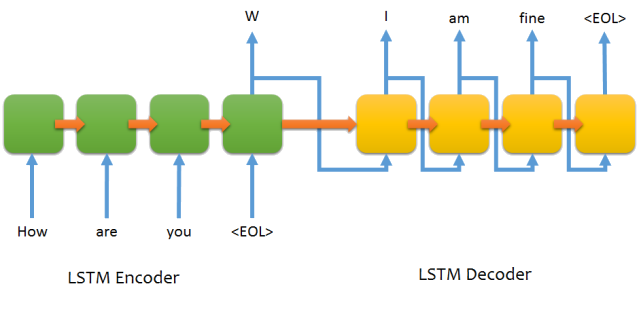

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class Encoder(nn.Module):
    def __init__(self, vocabulary, embedding_dim=128, hidden_dim=256,): 
        super().__init__()
        self._vocabulary = vocabulary
        self._emb = nn.Embedding(len(vocabulary), embedding_dim)
        self._gru = nn.GRU(
                input_size=embedding_dim, 
                hidden_size=hidden_dim, 
                num_layers=1, 
                batch_first=True,
                # dropout=0.4,
            )

    def forward(self, x):
        o = self._emb(x)
        o, h = self._gru(o)
        return o,h

In [17]:
class Decoder(nn.Module):
    
    def __init__(self, vocabulary, hidden_dim):
        super(Decoder, self).__init__()
        self._vocabulary = vocabulary
        
        self._emb = nn.Embedding(num_embeddings=len(vocabulary),embedding_dim=hidden_dim)
        self._gru = nn.GRU( 
                input_size=hidden_dim, 
                hidden_size=hidden_dim, 
                num_layers=1, 
                batch_first=True,
                # dropout=0.4,
            )
        self._lin = nn.Linear(in_features=hidden_dim, out_features=len(vocabulary),bias=True,)

    # генерируем выход модели
    def _forward_step(self,x,h):
        o = self._emb(x)
        o,h = self._gru(o,h)
        o = self._lin(o)
        o = F.log_softmax(o,dim=-1)
        return o,h
    
    # рабочий режим - по авторегрессионной схеме генерируем последовательность длиной seq_len
    def forward(self, encoder_hidden, seq_len=10): 
        device = next(self._lin.parameters()).device # устройство модели
        batch_size = encoder_hidden.size(1) # размер входного батча 
        codes = [] # выходная последовательность
        h = encoder_hidden # состояние энкодера передаём декодеру
        # начальный вход рекуррентного слоя
        o = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
        for i in range(seq_len):
            o, h  = self._forward_step(o,h) # авторегрессионная схема - выход подаём на вход
            o = torch.argmax(o,dim=-1, keepdim=False) # определяем номер токена-победителя
            codes.append(o.cpu().numpy()) # сохраняем результат
        return np.hstack(codes)
                
    # учебный режим - генерируем последовательность длинной как у target
    # по схеме teacher forcing, на каждой итерации заменяем вход на значение из target
    def forward_train(self, encoder_hidden, target):
        device = next(self._lin.parameters()).device # устройство модели
        batch_size = encoder_hidden.size(1) # размер входного батча 
        seq_len = target.size(-1) # длина учебной последовательности
        
        outputs = []  # выходы модели 

        # начальный вход рекуррентного слоя
        t = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
        h = encoder_hidden  # состояние энкодера передаём декодеру
        
        for i in range(seq_len):
            o, h = self._forward_step(t,h)
            outputs.append(o)
            # teacher forcing: заменяем выход модели на предыдущей итерации на target
            t = target[:,[i]].to(device)
        return torch.cat(outputs, dim=1)
    

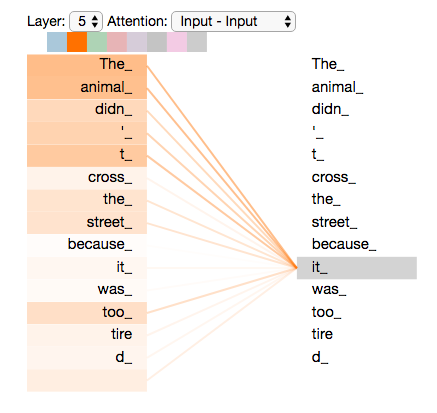

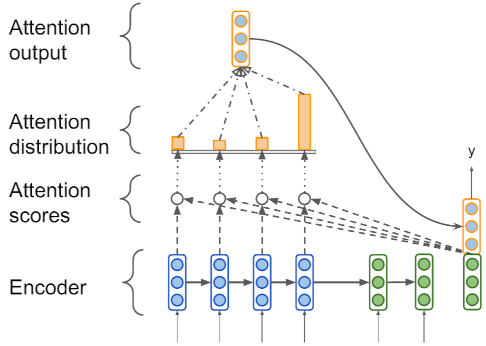

In [18]:
class DecoderAttention(Decoder):
    
    def __init__(self, vocabulary, hidden_dim, encoder_hidden_dim):
        super().__init__(vocabulary, hidden_dim)
        self._gru = nn.GRU( # добавляем атеншн-вектор ко входу декодера 
                input_size=hidden_dim+encoder_hidden_dim,
                hidden_size=hidden_dim, 
                num_layers=1, 
                batch_first=True,
                # dropout=0.4,
            )
        self._encoder_output = []
            
    # рабочий режим - по авторегрессионной схеме генерируем последовательность длиной seq_len
    def forward(self, encoder_output, seq_len=10): 
        self._encoder_output = encoder_output
        # финальное состояние энкодера передаём декодеру
        encoder_hidden = encoder_output[:,[-1],:].swapaxes(0,1) 
        return super().forward(encoder_hidden,seq_len) 

    # учебный режим - генерируем последовательность длинной как у target
    # по схеме teacher forcing, на каждой итерации заменяем вход на значение из target
    def forward_train(self, encoder_output, target):
        self._encoder_output = encoder_output
        # финальное состояние энкодера передаём декодеру
        encoder_hidden = encoder_output[:,[-1],:].swapaxes(0,1) 
        return super().forward_train(encoder_hidden,target)
    
    # генерируем выход модели
    def _forward_step(self,x,decoder_hidden):
        o = self._emb(x)
        a = self._attention( decoder_hidden )
        o = torch.cat([a,o],dim=-1) # добавляем атеншн ко входу декодера 
        o,h = self._gru(o,decoder_hidden)
        o = self._lin(o)
        o = F.log_softmax(o,dim=-1)
        return o,h
    
    def _attention(self,decoder_hidden):
        s = F.softmax( 
                ( self._encoder_output * decoder_hidden.swapaxes(0,1) ).sum(dim=-1,keepdim=True)
            , dim=-1 ) 
        return ( s*self._encoder_output ).sum(dim=1,keepdim=True)


In [19]:
# x,t = ds[:3]
# with torch.set_grad_enabled(False): # генерируем следующий токен
#     o,h = Encoder(vocabulary=ds.vocabulary, embedding_dim=128, hidden_dim=256,).forward(x)
#     c = DecoderAttention(vocabulary=ds.vocabulary, hidden_dim=256, encoder_hidden_dim=256,).forward(o)
#     #o = DecoderAttention(vocabulary=ds.vocabulary, hidden_dim=256, encoder_hidden_dim=256,).forward_train(o,t)
# np.hstack(c)

----

In [20]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [21]:
embedding_dim = 128
encoder_hidden_dim = 256

model_encoder = Encoder(
        vocabulary=ds.vocabulary, 
        embedding_dim=embedding_dim,
        hidden_dim=encoder_hidden_dim,
    ).to(device)

model_decoder = DecoderAttention( 
        vocabulary=ds.vocabulary, 
        hidden_dim=encoder_hidden_dim, 
        encoder_hidden_dim=encoder_hidden_dim,
    ).to(device)

# обучаем 

In [22]:
from torch import optim

learning_rate = 1e-3
encoder_optimizer = optim.Adam( model_encoder.parameters(), lr=learning_rate )
decoder_optimizer = optim.Adam( model_decoder.parameters(), lr=learning_rate )
criterion = nn.NLLLoss()

In [23]:
# история значений ф-ции потери
loss_history = [] 

In [24]:
from torch.utils.data import DataLoader

In [25]:
%%time

n_epoch = 128 # количество эпох обучения
batch_size = 1024

for i in tqdm(range(n_epoch)): 
    loss_batch = []
    
    # получаем батч учебных примеров
    for encoder_input_, target in DataLoader( ds, batch_size=batch_size, shuffle=True): 
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, _ = model_encoder(encoder_input_.to(device))
        decoder_outputs = model_decoder.forward_train( encoder_outputs, target )
        
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target.to(device).view(-1)
        )
        loss_batch.append(loss.item()) # дополняем историю изменения значений ф-ции потери на батче
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
   
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери


  0%|          | 0/128 [00:00<?, ?it/s]

CPU times: user 11min, sys: 2.16 s, total: 11min 2s
Wall time: 10min 51s


Text(0.5, 1.0, 'min loss: 0.00224')

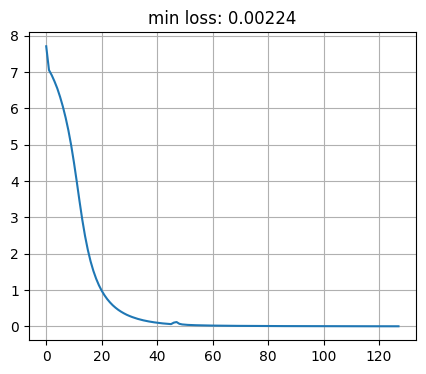

In [26]:
from matplotlib import pyplot as plt

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(loss_history)
ax.grid()
ax.set_title(f'min loss: {min(loss_history):.5f}')

# тестируем

In [27]:
from random import sample
from nltk.util import ngrams 

prompts = [
    ' '.join(ng) 
    for s in sample( ds.sentences,10 ) if len(s)>ds.sequence_len*2
    for ng in list(ngrams(s[:ds.sequence_len],ds.sequence_len))  
    ]

display( prompts )

['Я боялся своих неуверенных движений , боялся автомобилей ,',
 'Ни на одном другом языке , кроме русского ,',
 'Утренний клиент с Брайтона в город мне не попадался',
 '-- Четыре с половиной процента -- в месяц ...',
 'Пока я говорю в микрофон , пока крутятся бобины',
 'И тут наступила пренеприятнейшая минута : повернувшись ко мне',
 'Разумница Роза однако не стала дожидаться решения , и',
 'Но у тебя нет денег ... Неужели ты думаешь',
 'Пока погруженный в свои раздумья Фрэнк , стоя на',
 'Полисмен не ориентируется на фотографии , он не помнит']

In [28]:
# from random import sample
# from nltk.util import ngrams 

# prompts = [
#     ' '.join(ng) 
#     for s_ in sample([ s for s in  ds.sentences if len(s)>ds.sequence_len*2], 10 )
#     for ng in list( ngrams( s_, ds.sequence_len ) )  
#     ]

# display( prompts )

In [29]:
class LangModelSeq2SeqAttention: # генератор текста 
    
    def __init__(self,encoder,decoder,vocabulary):
        self._encoder = encoder 
        self._decoder = decoder 
        self._vocabulary = vocabulary # словарь языковой модели
        self._vocabulary_inv = { v:k for k,v in self._vocabulary.items() }
    
    def predict(self,prompt,seq_len=10):
        codes = self._predict( self._encode(prompt), seq_len) # генерируем коды токенов
        return self._strip_eos( self._decode(np.hstack(codes)) ) # конвертируем коды токенов в строку
    
    def _predict(self,x,seq_len):
        device = next(self._encoder.parameters()).device 
        with torch.set_grad_enabled(False): # генерируем следующий токен
            o,_ = self._encoder(x.to(device))
            codes = self._decoder.forward(o,seq_len)
        return codes
    
    def _encode(self,s): # кодируем строку
        s = nltk_tokenize_word(s,language='russian')
        s = [ self._vocabulary[w] for w in s if (w in self._vocabulary) ]
        return torch.tensor([s], dtype=torch.long )
    
    def _decode(self,s): # конвертируем коды токенов в строку
        return ' '.join([ 
            self._vocabulary_inv[c] 
            for c in s if (c in self._vocabulary_inv) 
        ])
    
    @staticmethod
    def _strip_eos(s, eos = '<EOS>'):
        n = s.find(eos)
        return s if n<0 else s[:n+len(eos)]

In [30]:
generator = LangModelSeq2SeqAttention(model_encoder,model_decoder,ds.vocabulary)
for prompt in prompts:
    t = generator.predict(prompt,seq_len=35)
    print(prompt,'==>', t,'\n')

Я боялся своих неуверенных движений , боялся автомобилей , ==> обгонявших нас , и все время наезжал на бровку . <EOS> 

Ни на одном другом языке , кроме русского , ==> не написано столько книг , за которые их авторы -- заплатили своими жизнями ... -- сколько же не написано столько книг , за которые их авторы -- заплатили своими жизнями ... -- сколько же так 

Утренний клиент с Брайтона в город мне не попадался ==> ни разу , и единственное , что запомнил я после удаления денег . <EOS> 

-- Четыре с половиной процента -- в месяц ... ==> Могильной жутью повеет на тебя от маленькой да удаленькой этой цифры на тебя от маленькой да удаленькой этой цифры на тебя от маленькой да удаленькой этой цифры на тебя от маленькой да удаленькой этой цифры 

Пока я говорю в микрофон , пока крутятся бобины ==> звукозаписывающей установки , я неотрывно слежу за выражением лица высокого седого ... Когда я неотрывно слежу за выражением лица высокого седого ... Когда я неотрывно слежу за выражением лица высок